### Use Monte Carlo to Price American Options

In this homework you will implement your own option pricer using American Monte Carlo (Monte Carlo + Regression) Based on the method prescribed by Longstaff and Schwartz.


Basic Procedures:
    
* Step 1: Simulate asset price paths for $S(t_i), i=1,2,..N$
* Step 2: Option value can be calculated explicitly for $t_N$: $p_k(t_N) = \max(K - S_k(t_N), 0) $ for path k;
* Step 3: Set $i=N$;
* Step 4: Perform linear regression of $e^{-r\Delta t}p_k(t_i)$ against basis function $f_j(S(t_{i-1})) = S(t_{i-1})^{j}$
* Step 5: Use the regression coefficients to estimate the continuation value at $t_{i-1}$: $C(t_{i-1})=\sum^{J}_{j=0} \beta^{i}_{j} f_j(S(t_{i-1}))$
* Step 6: Set option value $p_k(t_{i-1}) = \max(\max(K - S_k(t_{i-1}),0), C_k(t_{i-1}))$
* Step 7: If $i>1$, Set $i=i-1$, go back to step 3. Otherwise terminate.

Return option price as the mean of $e^{-r\Delta t}p_k(t_{1})$

Some code has been provided to you.  Your task is to:

1. (Mandatory) Fill in the blanks where the code is missing (whereever there is an indication "YOUR CODE HERE") <br>
2. Implement the following extension:<br>
  * (Mandatory) Try with different number of basis functions (default is 6): 2,3,4,5,6,9,10,20. Plot the option prices against these different orders and write down the observations in your report. 
  * (Optional) Try to extend the stock simulation model with stochastic volatility (Heston Model), i.e., replace $\sigma$ in the equation with a stochastic one:
$d S_t = r S_t dt + \sqrt{V_t} S_t dW_t $,  where $ d V_t = \kappa( \theta - V_t) dt + \eta \sqrt{V_t} d B_t$, $d[W_t, B_t] = \rho dt$.  Modify the pricer accordingly and compare the option price with the constant volatility case. 
3. (Mandatory) Prepare and submit a report in the form of powerpoint.  You will be asked to present it during the last lecture. 

In [1]:
import pandas as pd
import numpy as np
price_path=pd.DataFrame({'Path':np.arange(1,9,1), 't=0':np.ones(8), 't=1':[1.09,1.16,1.22,.93,1.11,.76,.92,.88],
                      't=2':[1.08,1.26,1.07,0.97,1.56,.77,.84,1.22],
                      't=3':[1.34,1.54,1.03,.92,1.52,.90,1.01,1.34]})
price_path.copy()

,Path,t=0,t=1,t=2,t=3
0,1,1.0,1.09,1.08,1.34
1,2,1.0,1.16,1.26,1.54
2,3,1.0,1.22,1.07,1.03
3,4,1.0,0.93,0.97,0.92
4,5,1.0,1.11,1.56,1.52
5,6,1.0,0.76,0.77,0.90
6,7,1.0,0.92,0.84,1.01
7,8,1.0,0.88,1.22,1.34


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [3]:
#Generate the stock price paths:
def sim_stock_price_GBM(S0, r, sigma, N_sim, N_T, dt):
        
    # Generate paths for underlying asset prices
    innovation = np.random.randn(N_sim, N_T)
    BM = np.zeros([N_sim, N_T+1])
    BM[:,0] = 0
    BM[:,1:] = innovation
    BM = np.cumsum(BM,axis=1)
    BM *= np.sqrt(dt)

    S = np.ones([N_sim, N_T+1])
    S[:,0] = 0
    S = S.cumsum(axis=1)
    S *= (r - 0.5*(sigma)**2)*dt
    S += sigma * BM
    S = S0*np.exp(S)
    
    return S

In [4]:
def AMC(S0,K,r,sigma, N_sim, T, dt, N_basis=6):
    N_T = int(T/dt)
    t = np.linspace(0,T,N_T+1)

    # Simulate stock prices
    S= sim_stock_price_GBM(S0, r, sigma, N_sim, N_T,dt)
    
    # Now backward induction & regression
    i = N_T
    
    Cont = np.zeros(N_sim)  # This stores the continuation value. 
    
    while i > 1:
        # First calculate option price
        p = np.maximum(K-S[:,i],0) # YOUR CODE HERE
        x = S[:,i-1]  # This is your predictive variable (x). In your prediction you need to use x, x^2, x^3,...x^N, where N = # of basis
        # discounted option price
        p_disc = np.exp(-r*dt)*p   # This is your target variable (y)
        reg = np.poly1d(np.polyfit(x,p_disc,N_basis)) # YOUR CODE HERE
        
        Cont = np.maximum(reg(x),0) # YOUR CODE HERE
        i = i - 1
    
    p = np.maximum(p,Cont) # YOUR CODE HERE - final option price
    return np.exp(-r*dt)*np.mean(p)

## European Put price for comparison

In [5]:
from scipy.stats import norm
def European_Put(S0,K,r,sigma,T):
    d1 = (np.log(S0/K) + (r + 0.5*(sigma)**2))*T/(sigma*np.sqrt(T)) 
    d2 = d1 - sigma*np.sqrt(T)
    return np.exp(-r*T)*K*norm.cdf(-d2) - S0*norm.cdf(-d1)

In [10]:
European_Put(S0,K,r,sigma,T)

3.494842856345061

In [12]:
S0=100
K=95
r=0.1
sigma=0.23
N_sim=10000
T=2
dt=0.5
AMC(S0,K,r,sigma, N_sim, T, dt)

4.937898589899146

## Compare European and American Option prices under different underlying stock prices

In [13]:
S= [60,70,80,90,100,110,120]
option_Eur = [European_Put(ss,K,r,sigma,T) for ss in S ]
option_Am = [AMC_S(ss) for ss in S]
plt.plot(S, option_Eur, label='European Put Price')
plt.plot(S, option_Am, label='American Put price')
plt.legend()
plt.xlabel('Underlying Price')
plt.ylabel('Put Price')

NameError: name 'AMC_S' is not defined

## Compare American option prices under different number of basis

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


Text(0, 0.5, 'Option price')

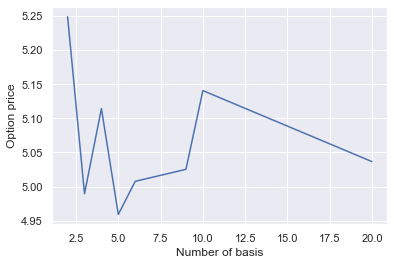

In [14]:
num_basis = [2,3,4,5,6,9,10,20]
option_prices=[]
for num in num_basis:
    c=AMC(S0,K,r,sigma, N_sim, T, dt,num)
    option_prices.append(c)
plt.plot(num_basis, option_prices)
plt.xlabel('Number of basis')
plt.ylabel('Option price')

In [15]:
def AMC_S(S):
    return AMC(S,K,r,sigma,N_sim,T,dt)

In [16]:
from ipywidgets import interact
import ipywidgets as widgets
interact(AMC_S, S=widgets.FloatSlider(min=50, max=120, step=5))

interactive(children=(FloatSlider(value=50.0, description='S', max=120.0, min=50.0, step=5.0), Output()), _dom…

<function __main__.AMC_S(S)>